In [12]:
import os
import pandas as pd

base_dir = "../../Data"
base_csv_path = os.path.join(base_dir, 'base.csv')
assert os.path.exists(base_csv_path), f"base {base_csv_path} does not exist"

output_csv_path = os.path.join(base_dir, 'm3_imputed.csv')
df = pd.read_csv(base_csv_path)

/tmp/ipykernel_13242/1683930076.py:9: DtypeWarning: Columns (2,64,91,94,97,106,108,109,110,111,112,114,116,119,120,122,127,139,142,143,144,145,152,153,154,155,156,157,159,160,161,163,164,165,169,170,171,172,175,178,179,180,187,189,215,216,217,218,219,317,318) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(base_csv_path)


In [13]:
# Replace "ethnicity" has been replaced with ethcat variable
desired_columns = ['thoracic_dgn', 'num_prev_tx', 'tah', 'vas', 'onvent', 'icu', 'inotropic', 'gender', 'abo',
                   'wgt_kg_tcr', 'hgt_cm_tcr', 'education', 'ecmo_tcr', 'iabp_tcr', 'inotropes_tcr', 'func_stat_tcr',
                   'diab', 'dial_ty_tcr', 'cereb_vasc', 'malig_tcr', 'most_rcnt_creat', 'tot_serum_album',
                   'hemo_co_tcr', 'cig_use', 'prior_card_surg_tcr', 'histry_cig_old', 'init_stat', 'init_creat',
                   'init_age', 'ethcat', 'init_hgt_cm_calc', 'init_wgt_kg_calc', 'ventilator_tcr', 'lvad_at_listing',
                   'rvad_at_listing', 'work_income_tcr', 'academic_level_tcr', 'tx_date', 'init_date']

df = df[desired_columns]

In [14]:
# Print number of rows with value 6 in ethcat before replacing values
print(f'Number of rows with value 6 in ethcat before replacing values: {len(df[df["ethcat"] == 6])}')

#1=1 (White), 2=2 (Black), 4=4 (Hispanic), 5=5 (Asian),6=6 (tidigare Amer Ind/Alaskan, kodas nu om till Other) 7=6 (tidigare Native Hawaiian, nu Other) 9=6 (tidigare Multiracial, nu Other)
df['ethcat'] = df['ethcat'].replace([7, 9, 998], 6)

#Print number of rows with value 6 in ethcat after replacing values
print(f'Number of rows with value 6 in ethcat after replacing values: {len(df[df["ethcat"] == 6])}')

Number of rows with value 6 in ethcat before replacing values: 450
Number of rows with value 6 in ethcat after replacing values: 1854


[Text(0.5, 0, 'Percentage of missing values'),
 Text(0, 0.5, 'Number of columns')]

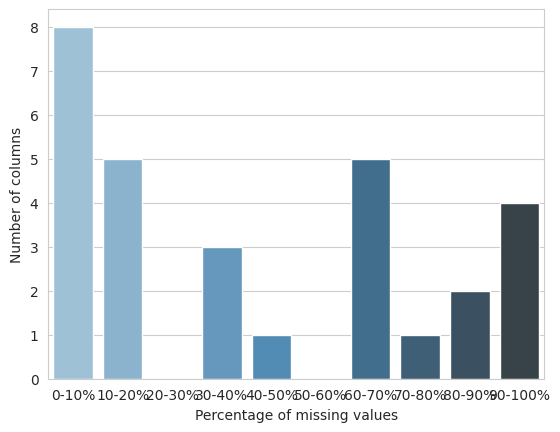

In [15]:
import seaborn as sns

missing_pct = df.isnull().sum() / len(df.index) * 100
bin_edges = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bin_labels = [f'{i}-{j}%' for i, j in zip(bin_edges[:-1], bin_edges[1:])]

# Bin the columns according to their missing value percentage
bins = pd.cut(missing_pct, bins=bin_edges, labels=bin_labels)

# Count the number of columns in each bin
bin_counts = bins.value_counts().sort_index()

# Create a bar plot of the bin counts
sns.set_style("whitegrid")
ax = sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="Blues_d")
ax.set(xlabel="Percentage of missing values", ylabel="Number of columns")

In [16]:
# Remove rows with no transplant date
pre_len = len(df.index)
df = df[df['tx_date'].notna()]
post_len = len(df.index)

print(f"Filtered to only transplanted patients: {post_len}/{pre_len} ({post_len / pre_len * 100:.2f}% remaining)")

# Compute the time to transplant (waitlist time -> wl_time)
df['wl_time'] = (
            pd.to_datetime(df['tx_date'], format='%d%b%Y') - pd.to_datetime(df['init_date'], format='%d%b%Y')).dt.days
df = df.drop(columns=['tx_date', 'init_date'])

Filtered to only transplanted patients: 77410/120264 (64.37% remaining)


In [17]:
# Remove columns where all values are missing
pre_len = len(df.columns)
df = df.dropna(axis=1, how='all')
post_len = len(df.columns)
print(
    f"Removed columns with all missing values: {pre_len - post_len}/{pre_len} ({(pre_len - post_len) / pre_len * 100:.2f}% removed)")

# Remove columns where there is no variance
pre_len = len(df.columns)
df = df.loc[:, df.nunique() != 1]
post_len = len(df.columns)
print(
    f"Removed columns with no variance: {pre_len - post_len}/{pre_len} ({(pre_len - post_len) / pre_len * 100:.2f}% removed)")


Removed columns with all missing values: 1/38 (2.63% removed)
Removed columns with no variance: 2/37 (5.41% removed)


In [18]:
from sklearn.preprocessing import OrdinalEncoder

# Find the categorical columns using nunique
categorical_columns = df.nunique()[df.nunique() < 10].index.tolist()
categorical_column_indexes = [df.columns.get_loc(c) for c in categorical_columns if c in df]

# Print the number of categorical columns
print(f"Number of categorical columns: {len(categorical_columns)}")
print(f"Categorical columns: {categorical_columns}")

Number of categorical columns: 23
Categorical columns: ['num_prev_tx', 'tah', 'vas', 'onvent', 'icu', 'inotropic', 'gender', 'abo', 'education', 'ecmo_tcr', 'iabp_tcr', 'inotropes_tcr', 'diab', 'dial_ty_tcr', 'cereb_vasc', 'malig_tcr', 'cig_use', 'prior_card_surg_tcr', 'histry_cig_old', 'ethcat', 'ventilator_tcr', 'work_income_tcr', 'academic_level_tcr']


In [19]:
print(
    f"Total number of missing values in categorical columns before replacing missing values with 'missing': {df[categorical_columns].isnull().sum().sum()}")

# For all categorical columns, replace missing values with the string "missing"
for col in categorical_columns:
    df[col] = df[col].fillna("missing")

#Convert categorical columns to strings
for col in categorical_columns:
    df[col] = df[col].astype(str)

print(
    f"Total number of missing values in categorical columns after replacing missing values with 'missing': {df[categorical_columns].isnull().sum().sum()}")


Total number of missing values in categorical columns before replacing missing values with 'missing': 571369
Total number of missing values in categorical columns after replacing missing values with 'missing': 0


In [20]:
#Split the dataframe into two dataframes, one for categorical columns and one for numerical columns
df_categorical = df[categorical_columns] 
df_numerical = df.drop(columns=categorical_columns)

#Print number of columns in each dataframe
print(f"Number of columns in df_categorical: {len(df_categorical.columns)}")
print(f"Number of columns in df_numerical: {len(df_numerical.columns)}")

#For each column in df_numberical, add another columns with the same name but with the suffix "_missing" that contains 1 if the value is missing and 0 if the value is not missing
for col in df_numerical.columns:
    df_numerical[col + "_missing"] = df_numerical[col].isnull().astype(int)

print(f"Number of columns pre merge in df: {len(df.columns)}")
print(f"Number of numerical columns pre merge: {len(df_numerical.columns)}")

#Concate df_categorical and df_numerical to one dataframe
df = pd.concat([df_categorical, df_numerical], axis=1)

print(f"Number of columns post merge in df: {len(df.columns)}")

df_sample = df[['most_rcnt_creat', 'most_rcnt_creat_missing']]
df_sample.sample(15)

Number of columns in df_categorical: 23
Number of columns in df_numerical: 12
Number of columns pre merge in df: 35
Number of numerical columns pre merge: 24
Number of columns post merge in df: 47


,most_rcnt_creat,most_rcnt_creat_missing
101316,1.40,0
88483,2.80,0
117960,0.50,0
47241,0.60,0
107077,1.06,0
55929,NaN,1
91183,0.80,0
55953,NaN,1
47775,NaN,1
97769,NaN,1


In [21]:
#Create a list of the categorical columns
categorical_columns = df.nunique()[df.nunique() < 10].index.tolist()

#Print number of categorical columns
print(f"Number of categorical columns: {len(categorical_columns)}")



Number of categorical columns: 35


In [22]:
#Print number of missing values in wl_tme
print(f'Number of missing values in wl_time: {df["wl_time"].isnull().sum()}')

#Print number of values in wl_time
print(f'Number of values in wl_time: {df["wl_time"].count()}')

wl_median = df['wl_time'].median()

#Print median of wl_time
print(f'Median of wl_time: {wl_median}')

Number of missing values in wl_time: 0
Number of values in wl_time: 77410
Median for wl_time: 78.0
Percentage of 0 and 1 in wl_time: 
1    50.188606
0    49.811394
Name: wl_time, dtype: float64
Number of missing values in wl_time: 0


In [23]:
# Impute the missing values using MissForest
from missingpy import MissForest

ordinal_encoder = OrdinalEncoder()
df[categorical_columns] = ordinal_encoder.fit_transform(df[categorical_columns])

wl_time_col = df.pop('wl_time')

#Get the indexes of categorical columns
categorical_column_indexes = [df.columns.get_loc(c) for c in categorical_columns if c in df]

imputer = MissForest()
df = pd.DataFrame(imputer.fit_transform(df, cat_vars=categorical_column_indexes), columns=df.columns)

df[categorical_columns] = ordinal_encoder.inverse_transform(df[categorical_columns])

df['wl_time'] = wl_time_col.values


/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensembl

Iteration: 0


/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensembl

Iteration: 1


/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensembl

Iteration: 2


/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensembl

Iteration: 3


/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/missingpy/missforest.py:406: RuntimeWarning: invalid value encountered in scalar divide
  gamma_newcat = np.sum(


In [24]:
df = pd.get_dummies(df, columns=categorical_columns)

# One hot encode the categorical columns
df.to_csv(output_csv_path, index=False)

/tmp/ipykernel_13242/2280144166.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.get_dummies(df, columns=categorical_columns)
/tmp/ipykernel_13242/2280144166.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.get_dummies(df, columns=categorical_columns)
/tmp/ipykernel_13242/2280144166.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.get_dummies(df, columns=categorical_columns)
/tmp/ipykernel_13242/2280144166.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.get_dummies(df, columns=categorical_columns)
/tmp/ipykernel_13242/2280144